In [44]:
import os
import string

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.base import BaseEstimator
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.autonotebook import tqdm

import spacy
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 

REGEX_TOKENIZER = RegexpTokenizer(r'\w+')
STOP_WORDS = set(stopwords.words('english'))
SEED = 2022
nlp = spacy.load("en_core_web_lg")

In [2]:
def remove_stop_words_from_document(doc, tokenizer=REGEX_TOKENIZER, stop_words=STOP_WORDS):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)

def remove_punctuation(doc):
    return doc.translate(str.maketrans('', '', string.punctuation))

def lemmatize_text(doc):
    lemmatized = list()
    with nlp.select_pipes(enable="lemmatizer"):
        for token in nlp(doc):
            lemma = token.lemma_.strip()
            lemmatized.append(lemma)
        
    return " ".join(lemmatized)

def preprocess_text(doc, lemmatize=True, tokenizer=REGEX_TOKENIZER, stop_words=STOP_WORDS):
    doc = remove_punctuation(doc)
    doc = remove_stop_words_from_document(doc, REGEX_TOKENIZER, STOP_WORDS)
    if lemmatize:
        doc = lemmatize_text(doc)
    
    return doc

def preprocess_annotations(df):
    accept_mask = df['answer'] == 'accept'
    cols = ['text', 'accept']
    df_prep = df.loc[accept_mask, cols]
    df_prep['accept'] = df_prep['accept'].apply(set)
    df_prep['accept'] = df_prep['accept'].apply(list)
    df_prep.reset_index(drop=True)
    
    return df_prep

In [3]:
fpath = r'C:\ProjectX\workspace\data\data_providers\gdelt\scraped_news\usa-news-annotated.jsonl'
df = pd.read_json(fpath, lines=True, encoding='utf-16')
df.head()

,text,_input_hash,_task_hash,spans,meta,options,accept,_view_id,config,answer,_timestamp
0,"By Jennifer De Pinto, Fred Backus, Anthony Sal...",1998789611,-135893388,"[{'text': 'gun', 'start': 485, 'end': 488, 'pa...","{'pattern': '61, 61, 61, 61, 61, 57, 61, 61, 6...","[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666862735
1,The epic decision by the US Supreme Court decl...,-1364136101,-553694219,"[{'text': 'gun', 'start': 234, 'end': 237, 'pa...","{'pattern': '61, 61, 61'}","[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666862983
2,"Governor Kathy Hochul has called for an ""extra...",1645904776,555948591,"[{'text': 'gun', 'start': 88, 'end': 91, 'patt...","{'pattern': '61, 58, 61, 60, 61, 60, 60, 58, 5...","[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666863272
3,"CHARLESTON, W.Va. (WV News) -- West Virginia l...",-616248505,-97240494,"[{'text': 'obscene', 'start': 3021, 'end': 302...",{'pattern': '21'},"[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666863386
4,"""For the first time now, in this pandemic, nea...",2145160317,1081617857,"[{'text': 'threat', 'start': 1362, 'end': 1368...",{'pattern': '9'},"[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666863439


In [6]:
df_prep = preprocess_annotations(df)
df_prep['text'] = df_prep['text'].apply(preprocess_text)
df_prep.head()

C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,text,accept
0,by jennifer de pinto fred backus anthony salva...,[]
1,the epic decision us supreme court declaring s...,[]
2,governor kathy hochul called extraordinary ses...,[]
3,charleston wva wv news west virginia lawmakers...,[]
4,for first time pandemic nearly every american ...,[]


In [7]:
# remove entries with unique tags to avoid error during train/test split
count_tags = df_prep['accept'].astype(str).value_counts()
mask = df_prep['accept'].astype(str).isin(count_tags[count_tags == 1].index.to_list())
df_prep_unique = df_prep[mask]
df_prep_split = df_prep.loc[~mask, :].copy()

# transofm tags to binary labels
mlb = MultiLabelBinarizer()
tags = mlb.fit_transform(df_prep_split['accept'])
df_prep_split[mlb.classes_] = tags

df_prep_split.tail()

,text,accept,ASSAULT,AUTO_THEFT,HARASSMENT,HOMICIDE,ROBBERY,THEFT
603,next example video title go video tempe ariz a...,[],0,0,0,0,0,0
604,police arrested woman last week suspicion cata...,[ASSAULT],1,0,0,0,0,0
605,american fork utah a man center outside walmar...,"[ASSAULT, THEFT]",1,0,0,0,0,1
606,john tooson double homicide suspect john tooso...,"[AUTO_THEFT, HOMICIDE]",0,1,0,1,0,0
607,a daviess county deputy shot man assaulted wom...,[ASSAULT],1,0,0,0,0,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df_prep_split['text'].to_list(), tags, train_size=0.75, stratify=tags, random_state=SEED, shuffle=True
)

X_train = X_train + df_prep_unique['text'].to_list()
y_train = np.vstack((y_train, mlb.transform(df_prep_unique['accept'])))

print(f'train: {len(X_train)} ({len(X_train)/len(df):.0%})\n'
      f'test: {len(X_test)} ({len(X_test)/len(df):.0%})')

train: 402 (66%)
test: 131 (22%)


In [39]:
def score(y_true, y_pred, threshold=0.5):
    """Calculate precision, recall, and f1 score"""
    predictions = np.where(y_pred >= threshold, 1, 0)
    metrics = precision_recall_fscore_support(y_true, predictions, average='weighted')
    performance = {'precision': metrics[0], 'recall': metrics[1], 'f1': metrics[2]}
    return performance
    #return pd.DataFrame(performance, index=[index])

In [61]:
def report(y_true, y_pred, target_names, threshold=0.5):
    predictions = np.where(y_pred >= threshold, 1, 0)
    cm = multilabel_confusion_matrix(y_true, predictions)
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

    for (i, label), ax in zip(enumerate(target_names), axs.ravel()):
        #row_sums = cm[i].sum(axis=1) 
        #matrix = (cm[i] / row_sums[:, np.newaxis]).round(4)
        sns.heatmap(cm[i], annot=True, fmt='g', ax=ax, cmap='Greens')

        # chart formatting
        ax.set_title(label)
        #ax.get_legend().remove()
        #ax.set_xlabel("")

    plt.show()

    print(classification_report(y_true, predictions, target_names=target_names))

# Training conventional ML

In [53]:
vectorizer_params = {
    'decode_error': 'strict',
    'encoding': 'utf-8',
    'strip_accents': 'ascii',  # {'ascii', 'unicode'}, default=None
    'lowercase': False,
    'tokenizer': None,  #  Override the string tokenization step while preserving the preprocessing and n-grams generation steps.
    'stop_words': None,  #: {'english'}, list, default=None. If 'english', a built-in stop word list for English is used. There are several known issues with 'english' and you should consider an alternative (see :ref:`stop_words`).
    'ngram_range': (1, 2),
    'analyzer': 'word',
    'max_df': 1.0,  # when building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    'min_df': 1,  # when building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
    'max_features': None,  # If not None, build a vocabulary that only consider the top
}

vectorizer = CountVectorizer(**vectorizer_params)

train_vectorizer_output = vectorizer.fit(X_train)
vocab = vectorizer.get_feature_names_out()
print(f"Size of vocab: {len(vocab)}\n")

# Applying Vectorizer to both train and test
train_vectorizer_output = vectorizer.transform(X_train)
test_vectorizer_output = vectorizer.transform(X_test)

print(f"Train: {train_vectorizer_output.shape}")
print(f"Test: {test_vectorizer_output.shape}")

train_word_list = vectorizer.get_feature_names();    
train_count_list = train_vectorizer_output.toarray().sum(axis=0)  

train_word_count = {k: v for k, v in sorted(zip(train_word_list, train_count_list), key=lambda item: item[1], reverse=True)}
train_word_count

Size of vocab: 64042

Train: (402, 64042)
Test: (131, 64042)


C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'police': 946,
 'the': 939,
 'said': 916,
 'county': 373,
 'man': 310,
 'shot': 232,
 'two': 228,
 'one': 227,
 'he': 222,
 'shooting': 222,
 'according': 220,
 'also': 208,
 'officers': 207,
 'police said': 199,
 'arrested': 198,
 'people': 195,
 'suspect': 195,
 'department': 180,
 'us': 180,
 'office': 178,
 'state': 173,
 'say': 172,
 'sheriffs': 171,
 'nt': 165,
 'vehicle': 160,
 'block': 159,
 'new': 154,
 'woman': 149,
 'found': 148,
 'murder': 144,
 'news': 142,
 'around': 141,
 'law': 141,
 'street': 140,
 'time': 138,
 'pm': 130,
 'in': 129,
 'victim': 128,
 'incident': 127,
 'thursday': 126,
 'car': 125,
 'taken': 125,
 'investigation': 123,
 'information': 121,
 'assault': 119,
 'city': 119,
 'sheriffs office': 118,
 'county sheriffs': 114,
 'deputies': 113,
 'report': 110,
 'scene': 110,
 'home': 109,
 'hospital': 109,
 'police department': 109,
 'we': 109,
 'near': 108,
 'reported': 108,
 'first': 106,
 'monday': 106,
 'charged': 104,
 'crime': 104,
 'would': 104,
 'area

## Logistic regression

In [62]:
logreg_params = {
    'penalty': 'l2',
    'tol': 0.01,
    'C': 50.0,
    'class_weight': 'balanced',
    'random_state': SEED,
    'solver': 'lbfgs',
    'max_iter': 100,
    'multi_class': 'auto'
}

base_lr = LogisticRegression(**logreg_params)

text_clf_lr = Pipeline([
    ('vect', CountVectorizer(**vectorizer_params)),
    ('tfidf', TfidfTransformer()),
    ('clf', ClassifierChain(base_lr, order='random', random_state=SEED)),
])

text_clf_lr.fit(X_train, y_train)

train_predicted_lr = text_clf_lr.predict_proba(X_train)
test_predicted_lr = text_clf_lr.predict_proba(X_test)

train_accuracy_lr = score(y_train, train_predicted_lr)
test_accuracy_lr = score(y_test, test_predicted_lr)

print("Logistic Regression")
print(f"- Train accuracy: {train_accuracy_lr}")
print(f"- Test accuracy: {test_accuracy_lr}")

Logistic Regression
- Train accuracy: {'precision': 0.9948170603343017, 'recall': 1.0, 'f1': 0.9973783609387631}
- Test accuracy: {'precision': 0.6950563700220451, 'recall': 0.4782608695652174, 'f1': 0.540418911908083}


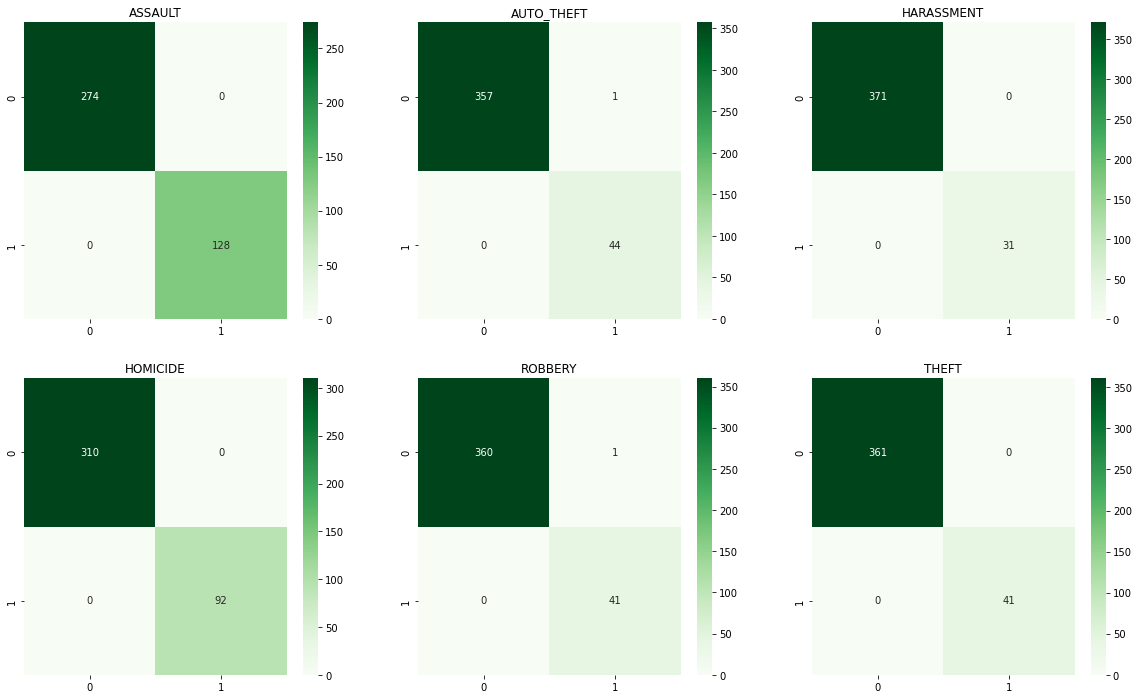

              precision    recall  f1-score   support

     ASSAULT       1.00      1.00      1.00       128
  AUTO_THEFT       0.98      1.00      0.99        44
  HARASSMENT       1.00      1.00      1.00        31
    HOMICIDE       1.00      1.00      1.00        92
     ROBBERY       0.98      1.00      0.99        41
       THEFT       1.00      1.00      1.00        41

   micro avg       0.99      1.00      1.00       377
   macro avg       0.99      1.00      1.00       377
weighted avg       0.99      1.00      1.00       377
 samples avg       0.59      0.59      0.59       377



C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
report(y_train, train_predicted_lr, target_names=mlb.classes_)

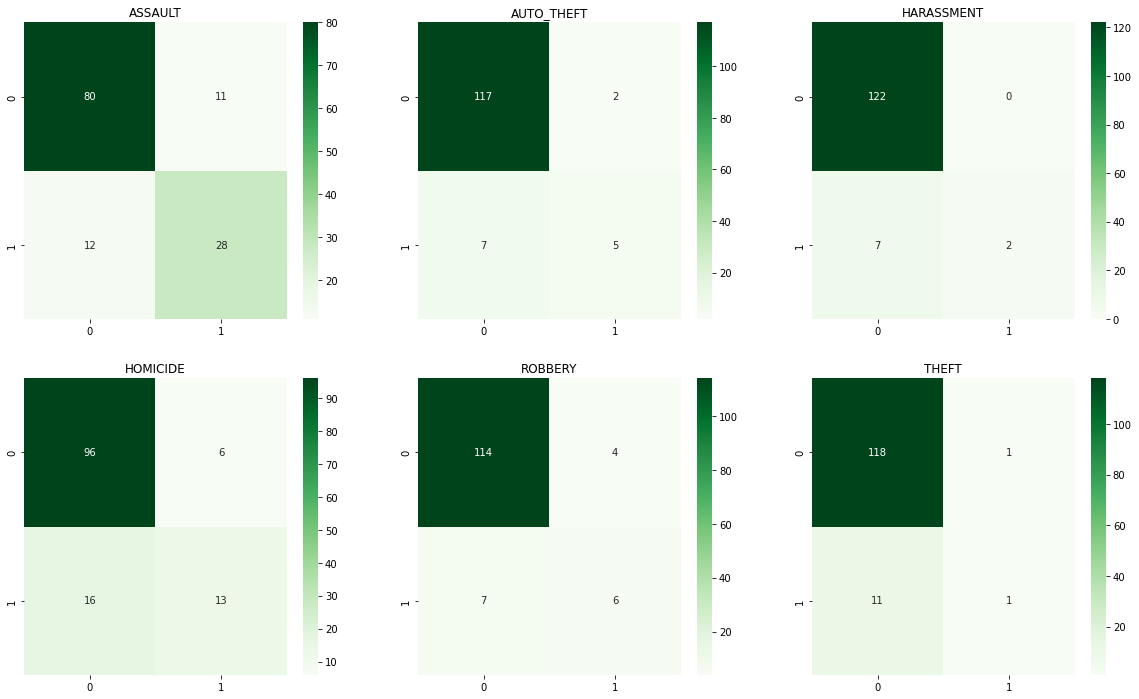

              precision    recall  f1-score   support

     ASSAULT       0.72      0.70      0.71        40
  AUTO_THEFT       0.71      0.42      0.53        12
  HARASSMENT       1.00      0.22      0.36         9
    HOMICIDE       0.68      0.45      0.54        29
     ROBBERY       0.60      0.46      0.52        13
       THEFT       0.50      0.08      0.14        12

   micro avg       0.70      0.48      0.57       115
   macro avg       0.70      0.39      0.47       115
weighted avg       0.70      0.48      0.54       115
 samples avg       0.32      0.28      0.29       115



C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
report(y_test, test_predicted_lr, target_names=mlb.classes_)